#  Implicit Neural Representation

Name: **Satish Vennapu**



In this assignment, you will get some hands-on experience with implicit neural representation (INR). With INR, we parameterize some signal (in our case images) with a neural network (in this assignment, we will use a basic feed-forward network). While in practice this might be useful for outpainting, super-resolution, and compression, in this assignment we will mainly focus on the basics, with some proof-of-concept outpainting at the end. Your outputs might not look great, this is okay as long as they are at least as good as the examples.

## Dataset

As always, we start with the data. In this section, you will need to complete the following steps:

1. Choose an image. If you're working in colab, you will need to either mount your Google Drive, or else upload the file directly.
2. Write SingleImageDataset. This is how you'll convert your image into model inputs and targets. You will instantiate the dataset and a dataloader to check and make sure you did this part correctly.

### Question 1: Selecting an image (5 points)

Free points! Just show your image here. One catch- make sure the image is less than 62500 pixels, total. We do not want you to waste time waiting for your model to train.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

IMage shape: torch.Size([3, 204, 304])
Total Pixels: 62016


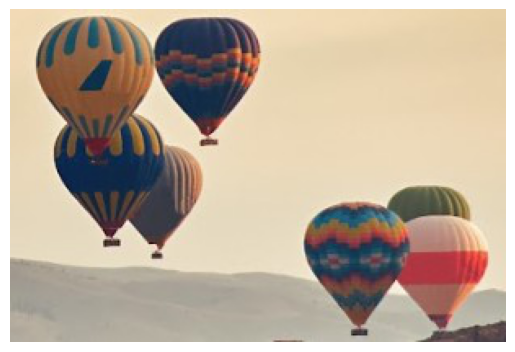

In [3]:
from torchvision.io import read_image  ## Note: feel free to use another loader
import matplotlib.pyplot as plt

image = read_image("sampleimage1.jpg")
print("IMage shape:", image.size())
print("Total Pixels:", image.shape[1]*image.shape[2])
plt.imshow(image.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()
plt.close()

### Question 2: Writing the dataset (20 points)

For this part, you need to fill in the blanks for the dataset provided below. Alternatively, feel free to write it from scratch, the scaffolding was provided to help you, not to trap you in a box.

You will also need to write a loop to construct the image, using a dataloader for your SingleImageDataset. We provide more details in comments below.

We will be grading your code and your image outputs. In Gradescope, make sure both are fully visible.

In [4]:
from torchvision.io import read_image
from torch.utils.data import Dataset

class SingleImageDataset(Dataset):
    def __init__(self, img_path):
        self.image = read_image(img_path)
        self.num_channels, self.h, self.w = self.image.shape

    def __len__(self):
        ### TODO: 1 line of code for returning the number of pixels
        return self.h*self.w

    def __getitem__(self, idx):
        ### TODO: 2-3 lines of code for x, y, and pixel values
        x = idx % self.w # column
        y = idx // self.w # row
        intensity = self.image[:, y, x]

        return {"x": x, "y": y, "intensity": intensity}

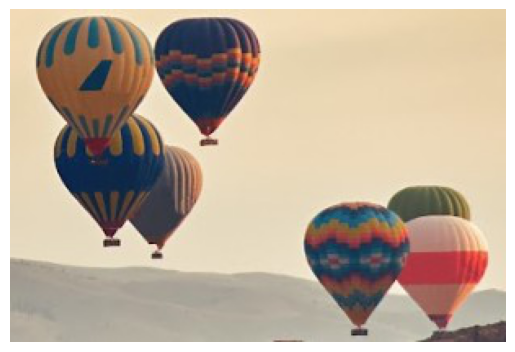

In [5]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

dataset = SingleImageDataset("sampleimage1.jpg")

### TODO: 1 line of code for initializing a DataLoader
dataloader = DataLoader(dataset, batch_size= 64, shuffle = True)

### TODO: 6-10 lines of code for using your dataloader to retrieve, reassemble,
###       and display your image
# creating an empty tensor
initial_image = torch.zeros((dataset.num_channels, dataset.h, dataset.w), dtype=torch.float32)
for batch in dataloader:
    x, y, intensity = batch["x"], batch["y"], batch["intensity"]
    # Batch iteration to assign values to individual pixels
    for i in range(batch["x"].shape[0]):
        initial_image[:, y[i], x[i]] = intensity[i]
# Normalization of pixels [0.0, 1.0]
image_normalized = initial_image / 255.0

plt.imshow(image_normalized.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

## Network


### Question 3: Defining the Network (15 points)

Define a feedforward neural network.
Remember that the last layer output dimension should be equal to the number of color channels.

A very basic network might have a linear layer, followed by a ReLU, followed by another linear layer.

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
from torch import nn

In [8]:
class FFN(torch.nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        ### TODO: define and initialize some layers with weights
        self.layers = nn.Sequential(
            nn.Linear(2, 4096),  # Input layer with 2 input features and 4096 output features
            nn.ReLU(),            # ReLU activation function
            nn.Linear(4096,2048),  # Hidden layer
            nn.ReLU(),          # ReLU activation function
            nn.Linear(2048, 1024),  # Hidden layer
            nn.ReLU(),          # ReLU activation function
            nn.Linear(1024, 512),  # Hidden layer with 512 output features
            nn.ReLU(),          # ReLU activation function
            nn.Linear(512, 256),  # Hidden layer with 256 output features
            nn.ReLU(),          # ReLU activation function
            nn.Linear(256, 3)    # Output layer with 3 output features
        )
    def forward(self, coord):
        out = self.layers(coord)
        return out


## Training

Now that you have a dataset and model, time to put it together!

Instantiate an optimizer and a criterion.
Loop over your dataset until the network converges.
Track your loss. We will be asking you to plot it later.

In [10]:
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler

torch.manual_seed(1)

net = FFN()

# since we are training the network for pixels,
# we will do a pixelwise MSE loss

## Inputs
#The learning rate for the optimizer
learning_rate = 0.01
# The number of training epochs
NUM_EPOCHS = 100
# The loss function to optimize
criterion = torch.nn.MSELoss() 
# device selected default cpu or cuda

## output Loss values

### TODO: 2 lines of code for optimizer, number of epochs


def train_model(model, dataloader, num_epochs,criterion, learning_rate=learning_rate, device='cpu'):

    # Move the model to the selected device either cpu or cuda
    model.to(device)
    # Initial a list to collect loss values
    loss_values = []
    criterion = torch.nn.MSELoss()
    # Set up Adam optimizer for the model
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Set up the l_r using the learning rate scheduler with a step of 20 epochs
    scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    for epoch in range(num_epochs):
        # Initial loss for the current epoch
        epoch_loss = 0.0  
        # training the model
        model.train()  
        for batch in tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            # Retrieve the batch data
            x, y, actual = batch["x"], batch["y"], batch["intensity"]
            x = x / dataset.w  # Normalizing x between 0 and 1
            y = y / dataset.h  # Normalizing y between 0 and 1
            # Moving data to the selected device cpu ir cuda
            x, y, actual = x.to(device).float(), y.to(device).float(), actual.to(device).float()
            # Forward pass
            predict = model(torch.stack((x,y), dim = 1))
            # loss value calcualtion for each
            loss = criterion(predict, actual)
            optimizer.zero_grad()
            # Backpropagation
            loss.backward()
            #optimization
            optimizer.step()
            epoch_loss += loss.item()

        # Adjust l_r using the learning rate scheduler
        scheduler.step()
        # Append all the loss values
        loss_values.append(epoch_loss / len(dataloader))
        # Print the epoch counter and loss
        print(f"Epoch Counter [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(dataloader)}")

    print('Training Done!')
    # Output loss values
    return loss_values

# Training the model
losses = train_model(net, dataloader, NUM_EPOCHS, criterion, learning_rate, device='cuda')



Epoch 1/100: 100%|██████████| 969/969 [00:10<00:00, 94.21it/s] 


Epoch Counter [1/100], Loss: 2857.1496629901962


Epoch 2/100: 100%|██████████| 969/969 [00:09<00:00, 98.71it/s] 


Epoch Counter [2/100], Loss: 1309.9902051171773


Epoch 3/100: 100%|██████████| 969/969 [00:10<00:00, 90.37it/s] 


Epoch Counter [3/100], Loss: 1052.3869362467951


Epoch 4/100: 100%|██████████| 969/969 [00:09<00:00, 101.83it/s]


Epoch Counter [4/100], Loss: 979.6287199951424


Epoch 5/100: 100%|██████████| 969/969 [00:09<00:00, 104.13it/s]


Epoch Counter [5/100], Loss: 856.395741213709


Epoch 6/100: 100%|██████████| 969/969 [00:09<00:00, 103.01it/s]


Epoch Counter [6/100], Loss: 811.521075600072


Epoch 7/100: 100%|██████████| 969/969 [00:09<00:00, 102.63it/s]


Epoch Counter [7/100], Loss: 772.98043056366


Epoch 8/100: 100%|██████████| 969/969 [00:09<00:00, 100.81it/s]


Epoch Counter [8/100], Loss: 685.7790232875891


Epoch 9/100: 100%|██████████| 969/969 [00:09<00:00, 101.20it/s]


Epoch Counter [9/100], Loss: 680.466065586905


Epoch 10/100: 100%|██████████| 969/969 [00:10<00:00, 96.75it/s] 


Epoch Counter [10/100], Loss: 671.5587945077933


Epoch 11/100: 100%|██████████| 969/969 [00:09<00:00, 100.24it/s]


Epoch Counter [11/100], Loss: 612.3498587121167


Epoch 12/100: 100%|██████████| 969/969 [00:09<00:00, 98.76it/s] 


Epoch Counter [12/100], Loss: 614.5416589821579


Epoch 13/100: 100%|██████████| 969/969 [00:09<00:00, 99.27it/s] 


Epoch Counter [13/100], Loss: 594.8333063273238


Epoch 14/100: 100%|██████████| 969/969 [00:10<00:00, 95.79it/s] 


Epoch Counter [14/100], Loss: 583.1100601023072


Epoch 15/100: 100%|██████████| 969/969 [00:09<00:00, 97.42it/s] 


Epoch Counter [15/100], Loss: 537.6428728448102


Epoch 16/100: 100%|██████████| 969/969 [00:09<00:00, 98.97it/s] 


Epoch Counter [16/100], Loss: 556.1509397366959


Epoch 17/100: 100%|██████████| 969/969 [00:09<00:00, 97.21it/s] 


Epoch Counter [17/100], Loss: 520.6653427974359


Epoch 18/100: 100%|██████████| 969/969 [00:09<00:00, 99.28it/s] 


Epoch Counter [18/100], Loss: 522.0465059073717


Epoch 19/100: 100%|██████████| 969/969 [00:09<00:00, 98.37it/s] 


Epoch Counter [19/100], Loss: 497.15324734115995


Epoch 20/100: 100%|██████████| 969/969 [00:11<00:00, 85.75it/s] 


Epoch Counter [20/100], Loss: 488.02893959257995


Epoch 21/100: 100%|██████████| 969/969 [00:11<00:00, 86.96it/s] 


Epoch Counter [21/100], Loss: 340.2540353591966


Epoch 22/100: 100%|██████████| 969/969 [00:09<00:00, 98.08it/s] 


Epoch Counter [22/100], Loss: 341.9822673738556


Epoch 23/100: 100%|██████████| 969/969 [00:09<00:00, 97.27it/s] 


Epoch Counter [23/100], Loss: 337.05190836116134


Epoch 24/100: 100%|██████████| 969/969 [00:09<00:00, 97.12it/s] 


Epoch Counter [24/100], Loss: 336.0059717845622


Epoch 25/100: 100%|██████████| 969/969 [00:09<00:00, 98.88it/s] 


Epoch Counter [25/100], Loss: 328.4848456604193


Epoch 26/100: 100%|██████████| 969/969 [00:09<00:00, 97.62it/s] 


Epoch Counter [26/100], Loss: 324.4656559065277


Epoch 27/100: 100%|██████████| 969/969 [00:09<00:00, 98.04it/s] 


Epoch Counter [27/100], Loss: 322.5783857536513


Epoch 28/100: 100%|██████████| 969/969 [00:09<00:00, 98.81it/s] 


Epoch Counter [28/100], Loss: 321.52460476193266


Epoch 29/100: 100%|██████████| 969/969 [00:09<00:00, 98.44it/s] 


Epoch Counter [29/100], Loss: 320.2142102464926


Epoch 30/100: 100%|██████████| 969/969 [00:09<00:00, 98.38it/s] 


Epoch Counter [30/100], Loss: 315.27542080401884


Epoch 31/100: 100%|██████████| 969/969 [00:09<00:00, 98.24it/s] 


Epoch Counter [31/100], Loss: 334.3324213333051


Epoch 32/100: 100%|██████████| 969/969 [00:09<00:00, 98.38it/s] 


Epoch Counter [32/100], Loss: 306.00071150205946


Epoch 33/100: 100%|██████████| 969/969 [00:09<00:00, 98.05it/s] 


Epoch Counter [33/100], Loss: 304.82021766796447


Epoch 34/100: 100%|██████████| 969/969 [00:09<00:00, 98.89it/s] 


Epoch Counter [34/100], Loss: 312.67965710052397


Epoch 35/100: 100%|██████████| 969/969 [00:09<00:00, 98.74it/s] 


Epoch Counter [35/100], Loss: 296.73659085489277


Epoch 36/100: 100%|██████████| 969/969 [00:10<00:00, 96.20it/s] 


Epoch Counter [36/100], Loss: 309.5136974007968


Epoch 37/100: 100%|██████████| 969/969 [00:09<00:00, 98.19it/s] 


Epoch Counter [37/100], Loss: 300.703790013143


Epoch 38/100: 100%|██████████| 969/969 [00:09<00:00, 99.14it/s] 


Epoch Counter [38/100], Loss: 297.2741635443625


Epoch 39/100: 100%|██████████| 969/969 [00:09<00:00, 99.61it/s] 


Epoch Counter [39/100], Loss: 283.9116824871492


Epoch 40/100: 100%|██████████| 969/969 [00:09<00:00, 98.39it/s] 


Epoch Counter [40/100], Loss: 301.20888626760006


Epoch 41/100: 100%|██████████| 969/969 [00:10<00:00, 96.43it/s] 


Epoch Counter [41/100], Loss: 215.99363819905724


Epoch 42/100: 100%|██████████| 969/969 [00:09<00:00, 97.63it/s] 


Epoch Counter [42/100], Loss: 214.74182883184884


Epoch 43/100: 100%|██████████| 969/969 [00:09<00:00, 98.29it/s] 


Epoch Counter [43/100], Loss: 209.09183341972107


Epoch 44/100: 100%|██████████| 969/969 [00:09<00:00, 98.65it/s] 


Epoch Counter [44/100], Loss: 214.84385587458024


Epoch 45/100: 100%|██████████| 969/969 [00:09<00:00, 98.20it/s] 


Epoch Counter [45/100], Loss: 211.33131617732093


Epoch 46/100: 100%|██████████| 969/969 [00:09<00:00, 98.56it/s] 


Epoch Counter [46/100], Loss: 205.3049512219503


Epoch 47/100: 100%|██████████| 969/969 [00:09<00:00, 98.82it/s] 


Epoch Counter [47/100], Loss: 210.34439803793703


Epoch 48/100: 100%|██████████| 969/969 [00:09<00:00, 98.88it/s] 


Epoch Counter [48/100], Loss: 205.8564531780987


Epoch 49/100: 100%|██████████| 969/969 [00:10<00:00, 96.73it/s] 


Epoch Counter [49/100], Loss: 201.0920968070488


Epoch 50/100: 100%|██████████| 969/969 [00:09<00:00, 98.71it/s] 


Epoch Counter [50/100], Loss: 217.16939463974646


Epoch 51/100: 100%|██████████| 969/969 [00:09<00:00, 97.80it/s] 


Epoch Counter [51/100], Loss: 204.72842428681776


Epoch 52/100: 100%|██████████| 969/969 [00:10<00:00, 94.85it/s] 


Epoch Counter [52/100], Loss: 201.2490828310373


Epoch 53/100: 100%|██████████| 969/969 [00:09<00:00, 98.60it/s] 


Epoch Counter [53/100], Loss: 207.39343162513


Epoch 54/100: 100%|██████████| 969/969 [00:09<00:00, 97.84it/s] 


Epoch Counter [54/100], Loss: 203.11479065760247


Epoch 55/100: 100%|██████████| 969/969 [00:09<00:00, 99.43it/s] 


Epoch Counter [55/100], Loss: 194.23591180728562


Epoch 56/100: 100%|██████████| 969/969 [00:09<00:00, 99.00it/s] 


Epoch Counter [56/100], Loss: 189.52161746030006


Epoch 57/100: 100%|██████████| 969/969 [00:09<00:00, 97.72it/s] 


Epoch Counter [57/100], Loss: 205.3748664304814


Epoch 58/100: 100%|██████████| 969/969 [00:09<00:00, 99.59it/s] 


Epoch Counter [58/100], Loss: 200.44769868171622


Epoch 59/100: 100%|██████████| 969/969 [00:09<00:00, 99.78it/s] 


Epoch Counter [59/100], Loss: 199.33720370392066


Epoch 60/100: 100%|██████████| 969/969 [00:09<00:00, 98.41it/s] 


Epoch Counter [60/100], Loss: 196.73339759897522


Epoch 61/100: 100%|██████████| 969/969 [00:09<00:00, 98.96it/s] 


Epoch Counter [61/100], Loss: 151.0190303967833


Epoch 62/100: 100%|██████████| 969/969 [00:09<00:00, 98.72it/s] 


Epoch Counter [62/100], Loss: 149.76453996467393


Epoch 63/100: 100%|██████████| 969/969 [00:09<00:00, 98.37it/s] 


Epoch Counter [63/100], Loss: 152.5516699130567


Epoch 64/100: 100%|██████████| 969/969 [00:09<00:00, 98.89it/s] 


Epoch Counter [64/100], Loss: 148.89230685435828


Epoch 65/100: 100%|██████████| 969/969 [00:09<00:00, 97.91it/s] 


Epoch Counter [65/100], Loss: 149.56670705797256


Epoch 66/100: 100%|██████████| 969/969 [00:09<00:00, 99.22it/s] 


Epoch Counter [66/100], Loss: 145.28643742335962


Epoch 67/100: 100%|██████████| 969/969 [00:09<00:00, 98.49it/s] 


Epoch Counter [67/100], Loss: 145.4367495616523


Epoch 68/100: 100%|██████████| 969/969 [00:09<00:00, 98.21it/s] 


Epoch Counter [68/100], Loss: 150.57157322792077


Epoch 69/100: 100%|██████████| 969/969 [00:09<00:00, 99.22it/s] 


Epoch Counter [69/100], Loss: 154.37409987119943


Epoch 70/100: 100%|██████████| 969/969 [00:09<00:00, 100.12it/s]


Epoch Counter [70/100], Loss: 145.95720229134102


Epoch 71/100: 100%|██████████| 969/969 [00:09<00:00, 99.97it/s] 


Epoch Counter [71/100], Loss: 142.63041226413597


Epoch 72/100: 100%|██████████| 969/969 [00:09<00:00, 99.80it/s] 


Epoch Counter [72/100], Loss: 144.71029046789903


Epoch 73/100: 100%|██████████| 969/969 [00:09<00:00, 100.08it/s]


Epoch Counter [73/100], Loss: 146.17986429291244


Epoch 74/100: 100%|██████████| 969/969 [00:09<00:00, 98.87it/s] 


Epoch Counter [74/100], Loss: 141.9992182370433


Epoch 75/100: 100%|██████████| 969/969 [00:09<00:00, 97.35it/s] 


Epoch Counter [75/100], Loss: 143.49780645262223


Epoch 76/100: 100%|██████████| 969/969 [00:09<00:00, 99.44it/s] 


Epoch Counter [76/100], Loss: 141.9758461341031


Epoch 77/100: 100%|██████████| 969/969 [00:09<00:00, 100.09it/s]


Epoch Counter [77/100], Loss: 145.22862796763764


Epoch 78/100: 100%|██████████| 969/969 [00:09<00:00, 99.76it/s] 


Epoch Counter [78/100], Loss: 143.41054037899178


Epoch 79/100: 100%|██████████| 969/969 [00:09<00:00, 100.37it/s]


Epoch Counter [79/100], Loss: 143.45007841505873


Epoch 80/100: 100%|██████████| 969/969 [00:09<00:00, 99.21it/s] 


Epoch Counter [80/100], Loss: 141.60145509599778


Epoch 81/100: 100%|██████████| 969/969 [00:09<00:00, 100.60it/s]


Epoch Counter [81/100], Loss: 120.38513182412728


Epoch 82/100: 100%|██████████| 969/969 [00:10<00:00, 92.73it/s] 


Epoch Counter [82/100], Loss: 118.68162498631591


Epoch 83/100: 100%|██████████| 969/969 [00:09<00:00, 96.93it/s] 


Epoch Counter [83/100], Loss: 118.91514148849944


Epoch 84/100: 100%|██████████| 969/969 [00:09<00:00, 100.05it/s]


Epoch Counter [84/100], Loss: 119.58666877825317


Epoch 85/100: 100%|██████████| 969/969 [00:09<00:00, 100.77it/s]


Epoch Counter [85/100], Loss: 118.90818402592488


Epoch 86/100: 100%|██████████| 969/969 [00:09<00:00, 100.59it/s]


Epoch Counter [86/100], Loss: 119.29257386387687


Epoch 87/100: 100%|██████████| 969/969 [00:09<00:00, 100.44it/s]


Epoch Counter [87/100], Loss: 117.16935971892902


Epoch 88/100: 100%|██████████| 969/969 [00:09<00:00, 102.05it/s]


Epoch Counter [88/100], Loss: 117.98004829083926


Epoch 89/100: 100%|██████████| 969/969 [00:09<00:00, 101.63it/s]


Epoch Counter [89/100], Loss: 118.28302749145634


Epoch 90/100: 100%|██████████| 969/969 [00:09<00:00, 99.74it/s] 


Epoch Counter [90/100], Loss: 116.94464226280819


Epoch 91/100: 100%|██████████| 969/969 [00:10<00:00, 96.23it/s] 


Epoch Counter [91/100], Loss: 117.34970219142666


Epoch 92/100: 100%|██████████| 969/969 [00:09<00:00, 99.12it/s] 


Epoch Counter [92/100], Loss: 117.0426748982401


Epoch 93/100: 100%|██████████| 969/969 [00:09<00:00, 101.28it/s]


Epoch Counter [93/100], Loss: 115.23763402499897


Epoch 94/100: 100%|██████████| 969/969 [00:09<00:00, 98.38it/s] 


Epoch Counter [94/100], Loss: 118.2577699025472


Epoch 95/100: 100%|██████████| 969/969 [00:09<00:00, 99.02it/s] 


Epoch Counter [95/100], Loss: 116.30250324331939


Epoch 96/100: 100%|██████████| 969/969 [00:09<00:00, 100.43it/s]


Epoch Counter [96/100], Loss: 116.08224790433366


Epoch 97/100: 100%|██████████| 969/969 [00:09<00:00, 98.45it/s] 


Epoch Counter [97/100], Loss: 114.12902334230972


Epoch 98/100: 100%|██████████| 969/969 [00:09<00:00, 100.06it/s]


Epoch Counter [98/100], Loss: 115.86097303927868


Epoch 99/100: 100%|██████████| 969/969 [00:09<00:00, 102.40it/s]


Epoch Counter [99/100], Loss: 114.34959623811169


Epoch 100/100: 100%|██████████| 969/969 [00:09<00:00, 99.80it/s] 

Epoch Counter [100/100], Loss: 115.7924422194222
Training Done!


### Question 4: Plot loss over time (20 points)

For this part, plot your loss from training the model.

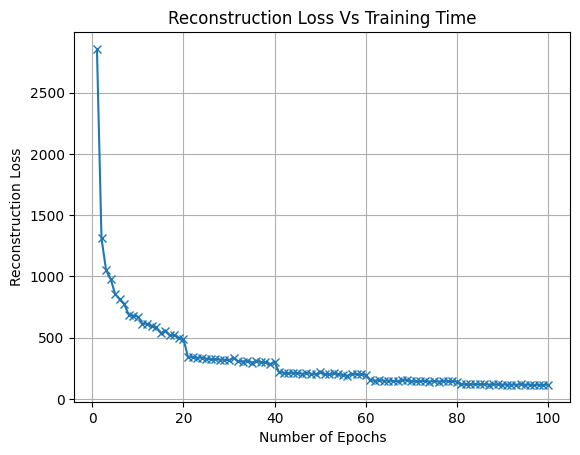

In [11]:
### TODO: make plot of reconstruction loss (y-axis) over training time (x-axis)
import matplotlib.pyplot as plt
plt.plot(range(1, NUM_EPOCHS + 1), losses, marker='x')
plt.title('Reconstruction Loss Vs Training Time')
plt.xlabel('Number of Epochs')
plt.ylabel('Reconstruction Loss')
plt.grid(True)
plt.show()

## Evaluation

### Question 5: Reconstruct whole image (20 points)

For this part, reconstruct the image using your model's outputs, at each coordinate.
You can use our scaffolding code, or write your own.
For this part, we are just grading the image plot, where you should plot the original image side-by-side with the reconstruction, as shown in this example.

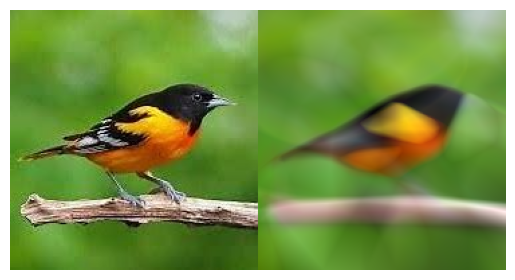

100%|██████████| 304/304 [01:17<00:00,  3.92it/s]


(-0.5, 303.5, 203.5, -0.5)

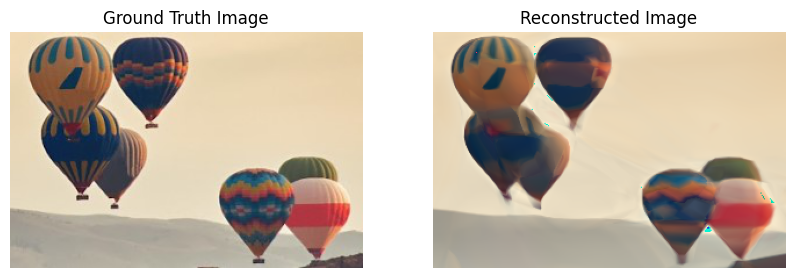

In [22]:
### TODO: ~12 lines of code to assemble ground_truth_img, build predicted_img

import torch
# the ground truth image
ground_truth_img = read_image("sampleimage1.jpg")
# the predicted image as an empty tensor 
predicted_img = torch.zeros_like(ground_truth_img)
# Iterate through (x, y) to predict the pixel values
for x in tqdm(range(ground_truth_img.shape[2])):
    for y in range(ground_truth_img.shape[1]):
        # Normalize x and y values between 0 and 1
        normalized_x = x / ground_truth_img.shape[2]
        normalized_y = y / ground_truth_img.shape[1]
        # Predict the pixel values at each of the coordinates
        predicted_intensity = net(torch.tensor([normalized_x, normalized_y]).to(device))
        # Update the predicted_image at each iteration with the predicted intensity
        predicted_img[:, y, x] = predicted_intensity
 
predicted_img = torch.clamp(predicted_img, 0, 255)
# Getting the predicted image to display
pred_display_image = predicted_img.clone().detach().cpu().permute(1, 2, 0)
# # Concatenate the ground truth image and predicted image using subplot
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the ground truth image and predicted image side by side
axes1.imshow(ground_truth_img.permute(1, 2, 0).detach().numpy())
axes1.set_title("Ground Truth Image")
axes1.axis('off')
axes2.imshow(pred_display_image.numpy())
axes2.set_title("Reconstructed Image")
axes2.axis('off')



### Question 6: Compute PSNR (10 points)

For this part, print the PSNR for your reconstruction vs. the original image. Feel free to use any libraries, or implement it from scratch.

In [23]:
### TODO: compute and print PSNR between reconstructed (predicted) and ground truth images
import numpy as np

# PSNR formula
# peak signal to noise ratio = 20*log10(max) - 10*log10(mse)
# Ground truth and predicted image in float values
ground_truth_img = ground_truth_img.float() / 255.0
predicted_img = predicted_img.float() / 255.0
# Create a tensor out of the max pixel value
max = torch.tensor(255.0)
# Compute the MSE
mse = torch.mean((ground_truth_img - predicted_img) ** 2)
# Compute the PSNR 
psnr = 20 * torch.log10(max) - 10 * torch.log10(mse)
print(f"PSNR: {psnr.item()} dB")


PSNR: 75.37994384765625 dB


### Question 7: Outpainting (10 points)

INR is a continuous image representation. What happens if your input coordinates don't correspond to real pixels? Try it out and show the result!

For this part, have your model predict 20 pixels in all directions that are outside the boundaries of the original image, and show the resulting image below. Also plot a box around the region corresponding to the original image, for clarity.

We show an example below.

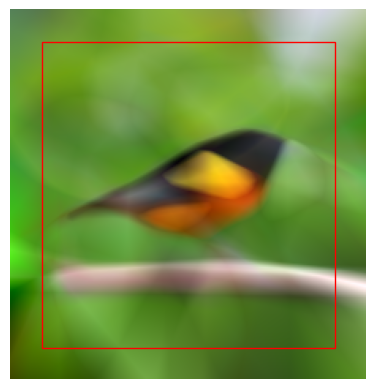

  0%|          | 0/344 [00:00<?, ?it/s]

100%|██████████| 344/344 [03:11<00:00,  1.80it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 343.5, 243.5, -0.5)

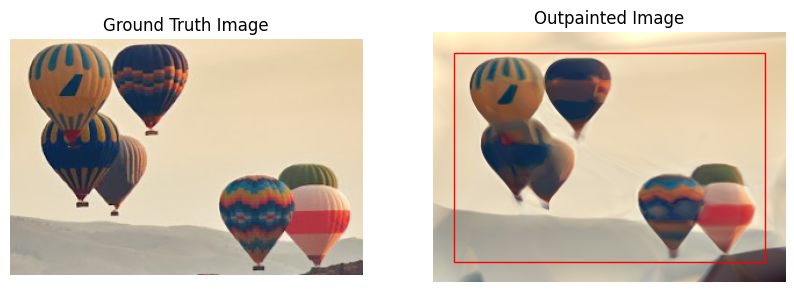

In [24]:

### TODO: 6-10 lines of code to generate outpainted image
import matplotlib.patches as patches

# The extended region outpainted by 20 pixels in all directions
outpainted_w = dataset.w + 40  
outpainted_h = dataset.h + 40  

# Outpainted image with the extended dimensions as empty tensor
outpainted_image = torch.zeros((3, outpainted_h, outpainted_w))

for x in tqdm(range(outpainted_w)):
    for y in range(outpainted_h):
      if x<304 or x>20 and y<204 or y>20:
        # Normalizing x and y values 
          normalized_x = (x-20) / 304
          normalized_y = (y-20) / 204
      pred_intensity = net(torch.tensor([normalized_x, normalized_y]).to(device))
      # Update the outpainted image at each iteration with the predicted intensity
      outpainted_image[:, y, x] = pred_intensity

# Get the outpainted image for displaying
display_image = outpainted_image.clone().detach().cpu().permute(1, 2, 0)

display_image_normalized = display_image / 255.0

# Create a rectangular region to the original image
rect = patches.Rectangle((20, 20), dataset.w, dataset.h, linewidth=1, edgecolor='r', facecolor='none')
# # Concatenate the ground truth image and predicted image using subplot
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(10, 5))
# Plot the ground truth image and predicted image side by side
axes1.imshow(ground_truth_img.permute(1, 2, 0).detach().numpy())
axes1.set_title("Ground Truth Image")
axes1.axis('off')
axes2.imshow(display_image_normalized.numpy())
axes2.add_patch(rect)
axes2.set_title("Outpainted Image")
axes2.axis('off')


## Bonus

The main idea of the bonus is to do something to make your model better than the one we walk you through in the assignment. Be creative! You can receive a maximum of 20 points for this portion.

### Question 8: Improve the Reconstruction Quality of the System (20 points, optional)

For this question, you must do two things:

1. Make a non-trivial change from what we guided you through in the assignment.
2. Prove that the change improves reconstruction quality. Compare your new output/PSNR to the old output/PSNR (plot the images, print the PSNR).

If you can't think of your own idea, revisit some of the literature from Shishira's guest lectures. For example, instead of taking raw coordinate inputs, you could try using positional encodings.

In [ ]:
### TODO: bonus